In [1]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import subplots

import glob
import warnings

import cv2

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('Keras version:', keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
warnings.simplefilter('default')

Keras version: 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12909259264976866922
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1881912553343854644
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3078765620878171630
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4319160135981977375
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


script to prep and save meta training data

In [2]:
mini_dataset_flag = False # set =True for debugging purpose
batch_size = 48
batch_size_predict = 128
input_shape = (224, 224)
top_model_weights_path = "top-Xception-model-weights.hdf5"
if mini_dataset_flag: top_model_weights_path = "mini-" + top_model_weights_path
save_info_flag = True
exclude_rare_labels = True

In [3]:
if mini_dataset_flag:
    #n_cat = 31
    data_path = './mini-datasets/'
    data = pd.DataFrame({'id': [], 'url': [], 'landmark_id': []})
    for filename in os.listdir(data_path):
        if filename.endswith(".jpg") or filename.endswith(".JPG"):
            data = data.append({'id': filename[:-4], 'url': 'fake_url', 'landmark_id': np.random.randint(low=0, high=231)}, ignore_index=True)
    print(" # of records inserted: " + str(len(data)))
    data = data.set_index('id')    
else:     
    data_path = './datasets/train/'
    data=pd.read_csv('train.csv', index_col='id')

n_cat = data['landmark_id'].nunique()
print(n_cat)

203094


In [4]:
data.head()

,url,landmark_id
id,,
6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [5]:
data_filtered = data.groupby('landmark_id').filter(lambda x : len(x)>100)
print('rare labels excluded')

data_filtered = data_filtered[data_filtered.landmark_id != 138982]
print('138982--excluded')

n_cat = data_filtered['landmark_id'].nunique()
print(n_cat)

rare labels excluded
138982--excluded
6401


In [6]:
def sample(df):
    return df.sample(n=min(len(df), 500), random_state=1)
data_filtered = data_filtered.groupby('landmark_id', group_keys=False).apply(sample)
n_cat = data_filtered['landmark_id'].nunique()
print(n_cat)

6401


In [7]:
def sample(df):
    return df.sample(frac=0.2, random_state=1)
dev_set = data_filtered.groupby('landmark_id', group_keys=False).apply(sample)
train_set = data_filtered.drop(dev_set.index)

print("dev set records: # " + str(len(dev_set)))
print("train set records: # " + str(len(train_set)))

dev set records: # 233026
train set records: # 932274


In [8]:
train_set.head()

,url,landmark_id
id,,
49567a7236b170ba,https://upload.wikimedia.org/wikipedia/commons...,27
350c35dd0e716f5d,https://upload.wikimedia.org/wikipedia/commons...,27
c74313b74dd3195d,https://upload.wikimedia.org/wikipedia/commons...,27
8323df4b0689d343,https://upload.wikimedia.org/wikipedia/commons...,27
5ffdeed07f56f8aa,https://upload.wikimedia.org/wikipedia/commons...,27


In [9]:
train_info = train_set.copy()
train_info['filename'] = data_path + train_info.index + '.jpg'
dev_info = dev_set.copy()
dev_info['filename'] = data_path + dev_info.index + '.jpg'

In [10]:
count_tmp=0
for index, row in train_info.iterrows():
    f = row['filename']
    if os.path.isfile(f) == False:
        count_tmp += 1
        train_info.at[index,'filename'] = f[:-4] + '.JPG'
print("# of records modified: " + str(count_tmp))

# of records modified: 670


In [11]:
count_tmp=0
for index, row in dev_info.iterrows():
    f = row['filename']
    if os.path.isfile(f) == False:
        count_tmp += 1
        dev_info.at[index,'filename'] = f[:-4] + '.JPG'
print("# of records modified: " + str(count_tmp))

# of records modified: 175


./datasets/train/0182a00fb45aef80.jpg


(144, 256, 3)

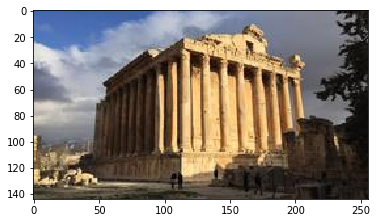

In [12]:
pick = np.random.choice(train_info['filename'])
print(pick)
testimg = cv2.cvtColor(cv2.imread(pick), cv2.COLOR_BGR2RGB)
plt.imshow(testimg)
testimg.shape

In [13]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)

train_info['label'] = label_encoder.fit_transform(train_info['landmark_id'].values)
train_info['one_hot'] = one_hot_encoder.fit_transform(
                   train_info['label'].values.reshape(-1, 1))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


In [14]:
train_info.head(10)

,url,landmark_id,filename,label,one_hot
id,,,,,
49567a7236b170ba,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/49567a7236b170ba.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
350c35dd0e716f5d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/350c35dd0e716f5d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
c74313b74dd3195d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/c74313b74dd3195d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
8323df4b0689d343,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/8323df4b0689d343.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
5ffdeed07f56f8aa,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/5ffdeed07f56f8aa.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
5658c5326df0e455,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/5658c5326df0e455.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
1b2be7599942441e,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/1b2be7599942441e.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
7ad8d5c2dd274f51,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/7ad8d5c2dd274f51.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
f6b0116aec0acf4b,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/f6b0116aec0acf4b.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [15]:
if save_info_flag and not(mini_dataset_flag): 
    if exclude_rare_labels:
        ss = 'D0527-ex-rare60-reduce-top-labels-'
    else:
        ss = 'D0527-all-labels-'
    data_store = pd.HDFStore(ss+'processed_data.h5')
    data_store['train_info'] = train_info
    data_store['dev_info'] = dev_info
    data_store.close()
    print('Done -- meta data saved to disk')

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['url', 'filename', 'one_hot']]

  exec(code_obj, self.user_global_ns, self.user_ns)


Done -- meta data saved to disk
